# Multi-Objective Optimization for Demand Curve

In general, we can model a demand curve where we predict quantity $q$ from price $p$ and other covariates.

$q = f(\theta) = f(p, x_0, x_1, \ldots, x_n)$

If we have the model $f(\theta)$, then we can find $(q^*, \theta^*)$ that maximizes either the total revenue or profit. Note the following.

- $r = qp$, and
- $t = q(p - c)$

where

- $r$ is the total revenue,
- $q$ is quantity,
- $p$ is unit price,
- $t$ is the total profit, and
- $c$ is the unit cost.

It is not necessarily the case that maximizing revenue is also maximizing profit. In this notebook, we will generate fake data and illustrate how we can model the demand curve and then use this model to optimize for revenue, profit and both.

## Data

The data is simulated as follows

$Q \sim \mathcal{N}(50 - 1.5 P + 100 M_q, 1) + \epsilon$,

where

- $Q$ is the quantity,
- $P$ is the unit price,
- $M_q$ is the corresponding yearly quarter for the specified month, and
- $\epsilon \sim \mathcal{N}(10, 5)$ is the error.

In [1]:
import numpy as np
import pandas as pd
import random

random.seed(37)
np.random.seed(37)

def f(p, month):
    e = np.random.normal(10, 5, p.shape[0])
    quarter = np.select([month < 4, month < 7, month < 11], [1, 2, 3], 4)
    return np.random.normal(50 - 1.5 * p + 100 * quarter) + e

df = pd.DataFrame({
        'p': np.random.randint(50, 100, 1_000),
        'month': np.random.randint(1, 12, 1_000)
    }) \
    .assign(q=lambda d: f(d['p'], d['month']))

## Visualize quantity over price trends

Below, we show the 

- spread of quantity by price and 
- also the sum of the quantity by price.

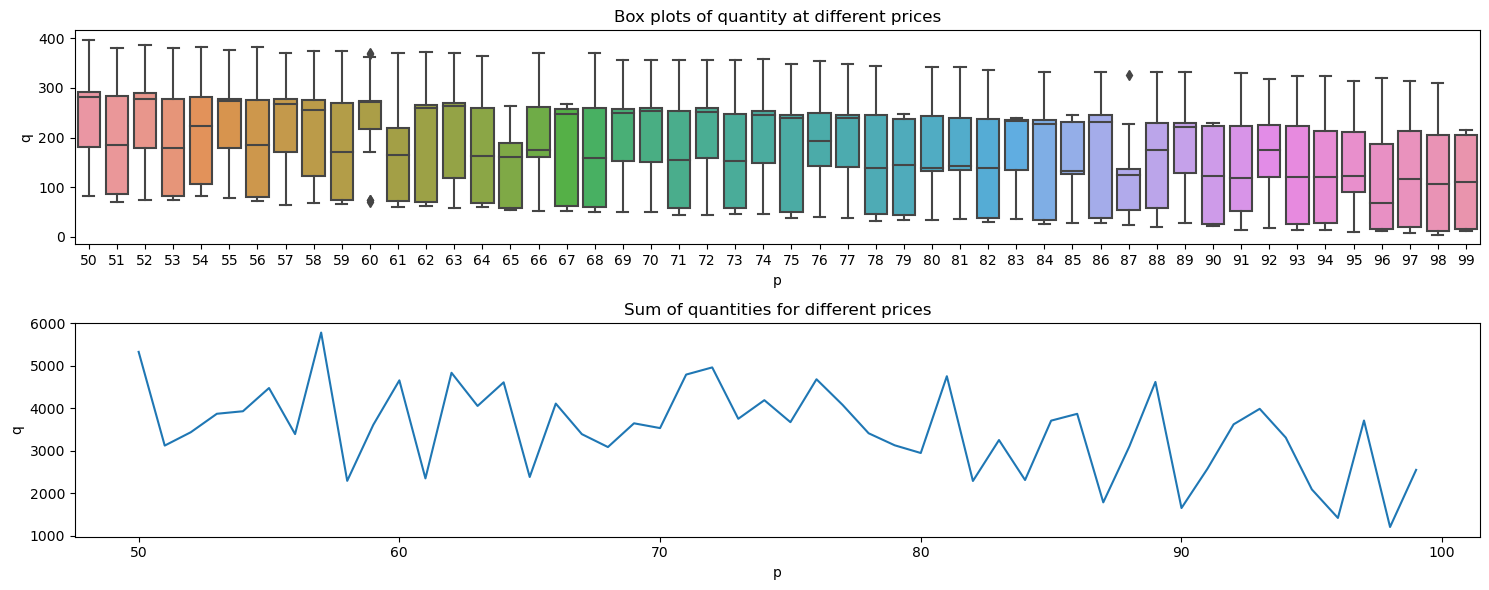

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

sns.boxplot(df, x='p', y='q', ax=ax[0])
df.groupby(['p'])['q'].sum().plot(kind='line', ylabel='q', ax=ax[1])

ax[0].set_title('Box plots of quantity at different prices')
ax[1].set_title('Sum of quantities for different prices')

fig.tight_layout()

We can breakdown the data by quarters and observe the spread of quantities by price. In all quarters except the last, all quantities trend downward. 

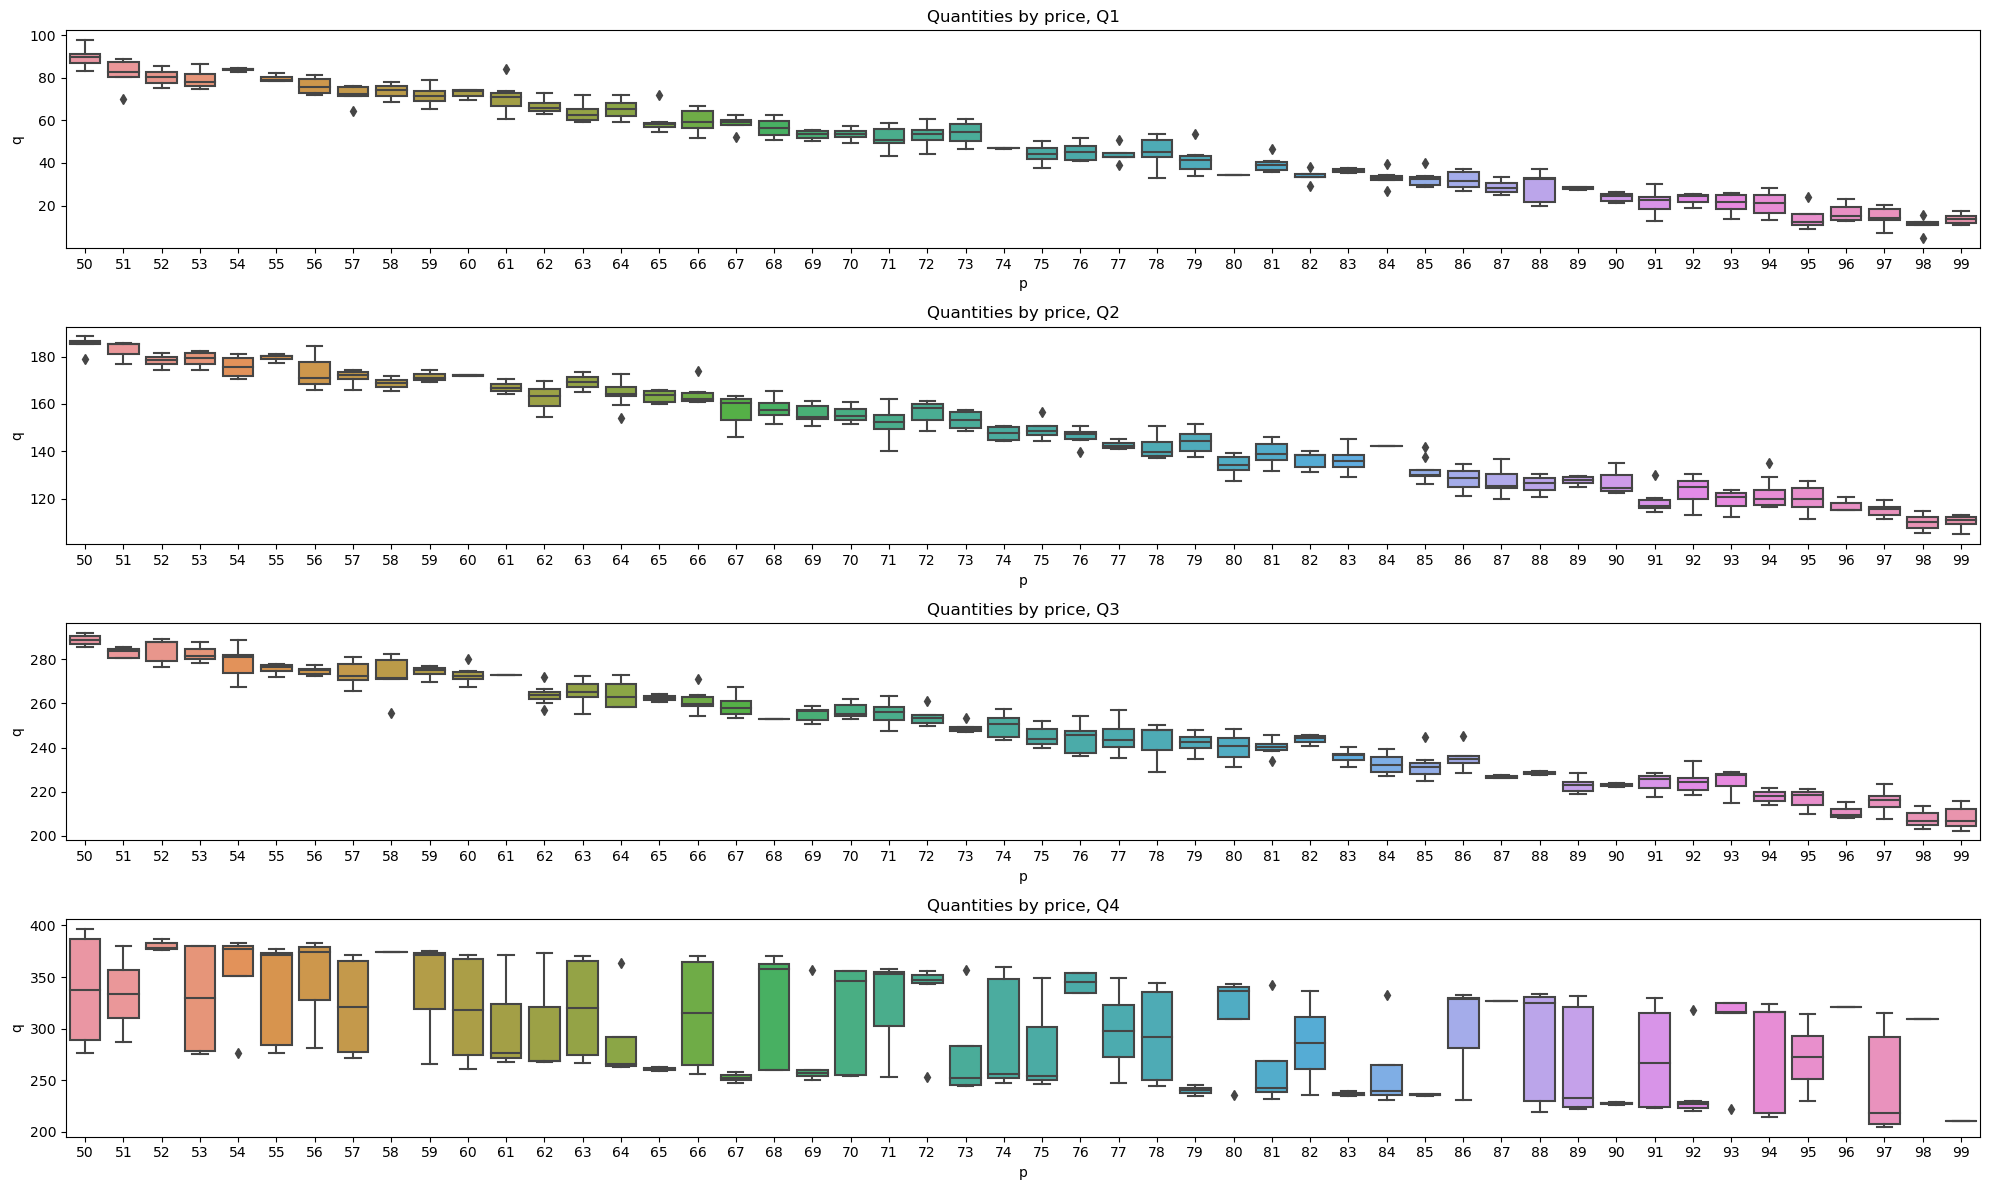

In [3]:
_temp = df.assign(quarter=lambda d: np.select([d.month < 4, d.month < 7, d.month < 10], [1, 2, 3], 4))

fig, axes = plt.subplots(4, 1, figsize=(20, 12))

for q, ax in zip([1, 2, 3, 4], np.ravel(axes)):
    sns.boxplot(
        _temp[_temp.quarter==q], 
        x='p', 
        y='q',
        ax=ax
    )

    ax.set_title(f'Quantities by price, Q{q}')

fig.tight_layout()

## Demand data

The demand curve data will be grouped by price-month and quantities summed over.

In [4]:
demand_df = df.groupby(['p', 'month'])['q'].sum().to_frame().reset_index()
demand_df

p  month           q
0    50      1   97.630858
1    50      2  170.132677
2    50      3  181.190757
3    50      4  367.611310
4    50      5  185.221784
..   ..    ...         ...
461  99      6  443.360809
462  99      7  210.213176
463  99      8  818.645468
464  99      9  430.012356
465  99     10  210.007255

[466 rows x 3 columns]

## Linear modeling

We can certainly model the demand curve using linear regression. As you can see below, the coefficient corresponding to price is `-3.20`. The mean absolute error `MAE` and weighted absolute percentage error `WAPE` are very big.

In [5]:
from sklearn.linear_model import LinearRegression

X = demand_df[['p', 'month']]
y = demand_df['q']

m = LinearRegression()
m.fit(X, y)

pd.Series([m.intercept_, m.coef_[0], m.coef_[1]], ['intercept', 'p', 'month'])

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


intercept    221.907460
p             -3.199247
month         66.123215
dtype: float64

In [6]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, m.predict(X))

175.57064604298589

In [7]:
np.sum(np.abs(y - m.predict(X))) / np.sum(y)

0.4666900845671383

## Non-linear modeling

In the non-linear modeling approach, we use a random forest to model the demand curve. Interestingly, `month` is more important than price. Also, using a non-linear model cuts the MAE and WAPE by over half of what we saw with the linear model. Let's keep this model.

In [8]:
from sklearn.ensemble import RandomForestRegressor

X = demand_df[['p', 'month']]
y = demand_df['q']

m = RandomForestRegressor(n_jobs=-1, random_state=37, n_estimators=40)
m.fit(X, y)

pd.Series(m.feature_importances_, X.columns)

p        0.434937
month    0.565063
dtype: float64

In [9]:
mean_absolute_error(y, m.predict(X))

76.80770760690886

In [10]:
np.sum(np.abs(y - m.predict(X))) / np.sum(y)

0.20416508320929747

## Visualizing quantities space

We can visualize the relationship between quantity (z-axis), price (x-axis) and month (y-axis). As you can tell, the surface is very complicated of how price and month interact to influence quantity.

In [11]:
x, y = np.meshgrid(np.arange(50, 100.1, 0.1), np.arange(1, 13, 1))
z = m.predict(pd.DataFrame([(_x, _y) for _x, _y in zip(np.ravel(x), np.ravel(y))], columns=['p', 'month'])).reshape(x.shape)

x.shape, y.shape, z.shape

((12, 501), (12, 501), (12, 501))

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(
    x=x,
    y=y,
    z=z,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$q = f(p, m_q)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='p')
fig.update_yaxes(title=r'$m_q$')

fig.show()

The contour plot is also complicated, but we can tell that the top region is where most of the high quantities reside from the interaction between month-quarter $m_q$ and price $p$.

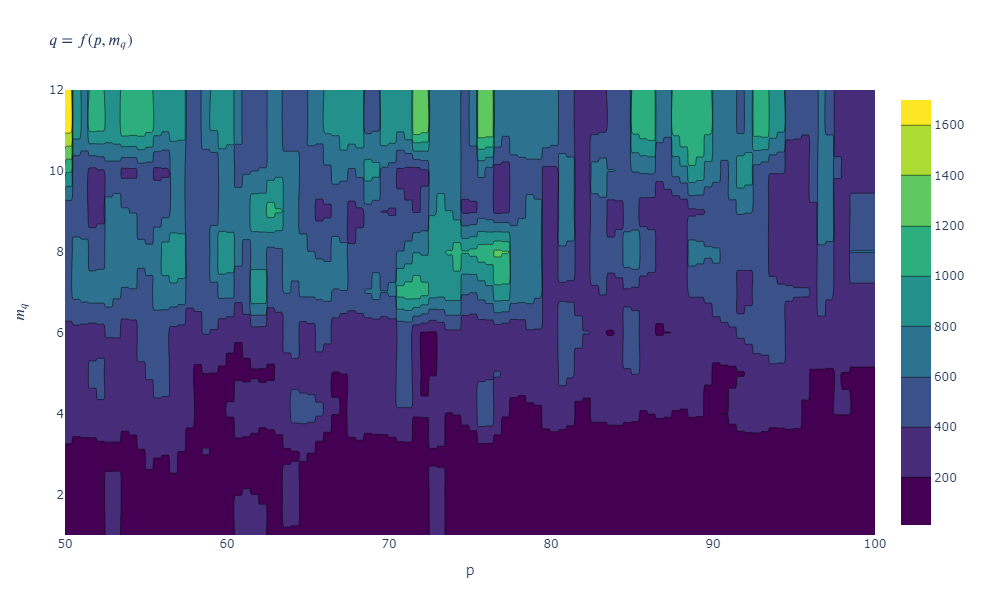

In [13]:
fig = go.Figure(data =
    go.Contour(
        z=z,
        x=np.unique(x),
        y=np.unique(y),
        colorscale='Viridis'
    ))
fig.update_layout(
    title=r'$q = f(p, m_q)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='p')
fig.update_yaxes(title=r'$m_q$')

fig.show()

## Maximize total revenue

Let's try to maximize total revenue.

In [15]:
import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)

def rev_objective(trial, m):
    p = trial.suggest_float('p', 50, 100)
    month = trial.suggest_float('month', 1, 12)
    _df = pd.DataFrame([[p, month]], columns=['p', 'month'])
    z = m.predict(_df)
    q = z[0]
    
    r = p * q
    
    return r

study = optuna.create_study(**{
    'study_name': 'opt-revenue',
    'storage': 'sqlite:///_temp/opt-revenue.db',
    'load_if_exists': True,
    'direction': 'maximize',
    'sampler': optuna.samplers.TPESampler(seed=37),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

study.optimize(**{
    'func': lambda t: rev_objective(t, m),
    'n_trials': 1_000,
    'n_jobs': 6,
    'show_progress_bar': True
})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
study.best_params

{'p': 88.4928117682058, 'month': 11.450811461657262}

In [17]:
study.best_value

103567.10107416332

In [18]:
_p = study.best_params['p']
_m = study.best_params['month']
_q = m.predict(pd.DataFrame([study.best_params]))[0]
_rev = _p * _q
_pft = (_p - 25) * _q

_rev_results = {
    'p': _p,
    'month': _m,
    'q': _q,
    'revenue': _rev,
    'profit': _pft
}

_rev_results

{'p': 88.4928117682058,
 'month': 11.450811461657262,
 'q': 1170.3447885173143,
 'revenue': 103567.10107416332,
 'profit': 74308.48136123046}

## Maximize total profit

Let's try to maximize profit.

In [19]:
def pft_objective(trial, m):
    p = trial.suggest_float('p', 50, 100)
    month = trial.suggest_float('month', 1, 12)
    _df = pd.DataFrame([[p, month]], columns=['p', 'month'])
    z = m.predict(_df)
    q = z[0]
    
    r = (p - 25) * q
    
    return r

study = optuna.create_study(**{
    'study_name': 'opt-profit',
    'storage': 'sqlite:///_temp/opt-profit.db',
    'load_if_exists': True,
    'direction': 'maximize',
    'sampler': optuna.samplers.TPESampler(seed=37),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

study.optimize(**{
    'func': lambda t: pft_objective(t, m),
    'n_trials': 1_000,
    'n_jobs': 6,
    'show_progress_bar': True
})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
study.best_params

{'p': 93.48324856585506, 'month': 11.324420125907485}

In [21]:
study.best_value

75902.68836214142

In [22]:
_p = study.best_params['p']
_m = study.best_params['month']
_q = m.predict(pd.DataFrame([study.best_params]))[0]
_rev = _p * _q
_pft = (_p - 25) * _q

_pft_results = {
    'p': _p,
    'month': _m,
    'q': _q,
    'revenue': _rev,
    'profit': _pft
}

_pft_results

{'p': 93.48324856585506,
 'month': 11.324420125907485,
 'q': 1108.3394837666272,
 'revenue': 103611.17545630709,
 'profit': 75902.68836214142}

## Maximize profit and revenue

Let's try to maximize both profit and revenue.

In [23]:
def rev_pft_objective(trial, m):
    p = trial.suggest_float('p', 50, 100)
    month = trial.suggest_float('month', 1, 12)
    _df = pd.DataFrame([[p, month]], columns=['p', 'month'])
    z = m.predict(_df)
    q = z[0]
    
    pft = (p - 25) * q
    rev = p * q
    
    return rev, pft

study = optuna.create_study(**{
    'study_name': 'opt-rev-pft',
    'storage': 'sqlite:///_temp/opt-rev-pft.db',
    'load_if_exists': True,
    'directions': ['maximize', 'maximize'],
    'sampler': optuna.samplers.TPESampler(seed=37),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

study.optimize(**{
    'func': lambda t: rev_pft_objective(t, m),
    'n_trials': 1_000,
    'n_jobs': 6,
    'show_progress_bar': True
})

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
best = max(study.best_trials, key=lambda t: (t.values[0], t.values[1]))

In [25]:
best

FrozenTrial(number=421, state=TrialState.COMPLETE, values=[103523.72177069388, 75815.2346765282], datetime_start=datetime.datetime(2023, 9, 7, 1, 15, 4, 325108), datetime_complete=datetime.datetime(2023, 9, 7, 1, 15, 5, 8747), params={'p': 93.40434342271607, 'month': 10.965941774282502}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'p': FloatDistribution(high=100.0, log=False, low=50.0, step=None), 'month': FloatDistribution(high=12.0, log=False, low=1.0, step=None)}, trial_id=422, value=None)

In [26]:
best.params

{'p': 93.40434342271607, 'month': 10.965941774282502}

In [27]:
best.values

[103523.72177069388, 75815.2346765282]

In [28]:
m.predict(pd.DataFrame([best.params]))[0]

1108.3394837666272

In [29]:
_p = best.params['p']
_m = best.params['month']
_q = m.predict(pd.DataFrame([best.params]))[0]
_rev = _p * _q
_pft = (_p - 25) * _q

_revpft_results = {
    'p': _p,
    'month': _m,
    'q': _q,
    'revenue': _rev,
    'profit': _pft
}

_revpft_results

{'p': 93.40434342271607,
 'month': 10.965941774282502,
 'q': 1108.3394837666272,
 'revenue': 103523.72177069388,
 'profit': 75815.2346765282}

## Maximize quantity, revenue and profit

In [ ]:
def q_rev_pft_objective(trial, m):
    p = trial.suggest_float('p', 50, 100)
    month = trial.suggest_float('month', 1, 12)
    _df = pd.DataFrame([[p, month]], columns=['p', 'month'])
    z = m.predict(_df)
    q = z[0]
    
    pft = (p - 25) * q
    rev = p * q
    
    return q, rev, pft

study = optuna.create_study(**{
    'study_name': 'opt-q-rev-pft',
    'storage': 'sqlite:///_temp/opt-q-rev-pft.db',
    'load_if_exists': True,
    'directions': ['maximize', 'maximize', 'maximize'],
    'sampler': optuna.samplers.TPESampler(seed=37),
    'pruner': optuna.pruners.MedianPruner(n_warmup_steps=10)
})

study.optimize(**{
    'func': lambda t: q_rev_pft_objective(t, m),
    'n_trials': 1_000,
    'n_jobs': 6,
    'show_progress_bar': True
})

In [58]:
best = max(study.best_trials, key=lambda t: (t.values[0], t.values[1]))

In [60]:
best.params

{'p': 50.184457378381126, 'month': 11.04879031751835}

In [59]:
best.values

[1640.2904172779429, 82317.08453405192, 41309.82410210335]

In [61]:
m.predict(pd.DataFrame([best.params]))[0]

1640.2904172779429

In [62]:
_p = best.params['p']
_m = best.params['month']
_q = m.predict(pd.DataFrame([best.params]))[0]
_rev = _p * _q
_pft = (_p - 25) * _q

_qrp_results = {
    'p': _p,
    'month': _m,
    'q': _q,
    'revenue': _rev,
    'profit': _pft
}

_qrp_results

{'p': 50.184457378381126,
 'month': 11.04879031751835,
 'q': 1640.2904172779429,
 'revenue': 82317.08453405192,
 'profit': 41309.82410210335}

The best parameters when maximizing for revenue, profit, revenue and profit and quantity, revenue and profit are shown below.

In [64]:
pd.DataFrame([
    _rev_results,
    _pft_results,
    _revpft_results,
    _qrp_results,
], index=['max_revenue', 'max_profit', 'max_both', 'max_all'])

p      month            q        revenue        profit
max_revenue  88.492812  11.450811  1170.344789  103567.101074  74308.481361
max_profit   93.483249  11.324420  1108.339484  103611.175456  75902.688362
max_both     93.404343  10.965942  1108.339484  103523.721771  75815.234677
max_all      50.184457  11.048790  1640.290417   82317.084534  41309.824102

## Visualize monthly revenue and profit

Below, we visualize expected revenue and profit over price for each month.

- $p_q$ is the price that optimizes the quantity
- $p_r$ is the price that optimizes the revenue
- $p_p$ is the price that optimizes the profit

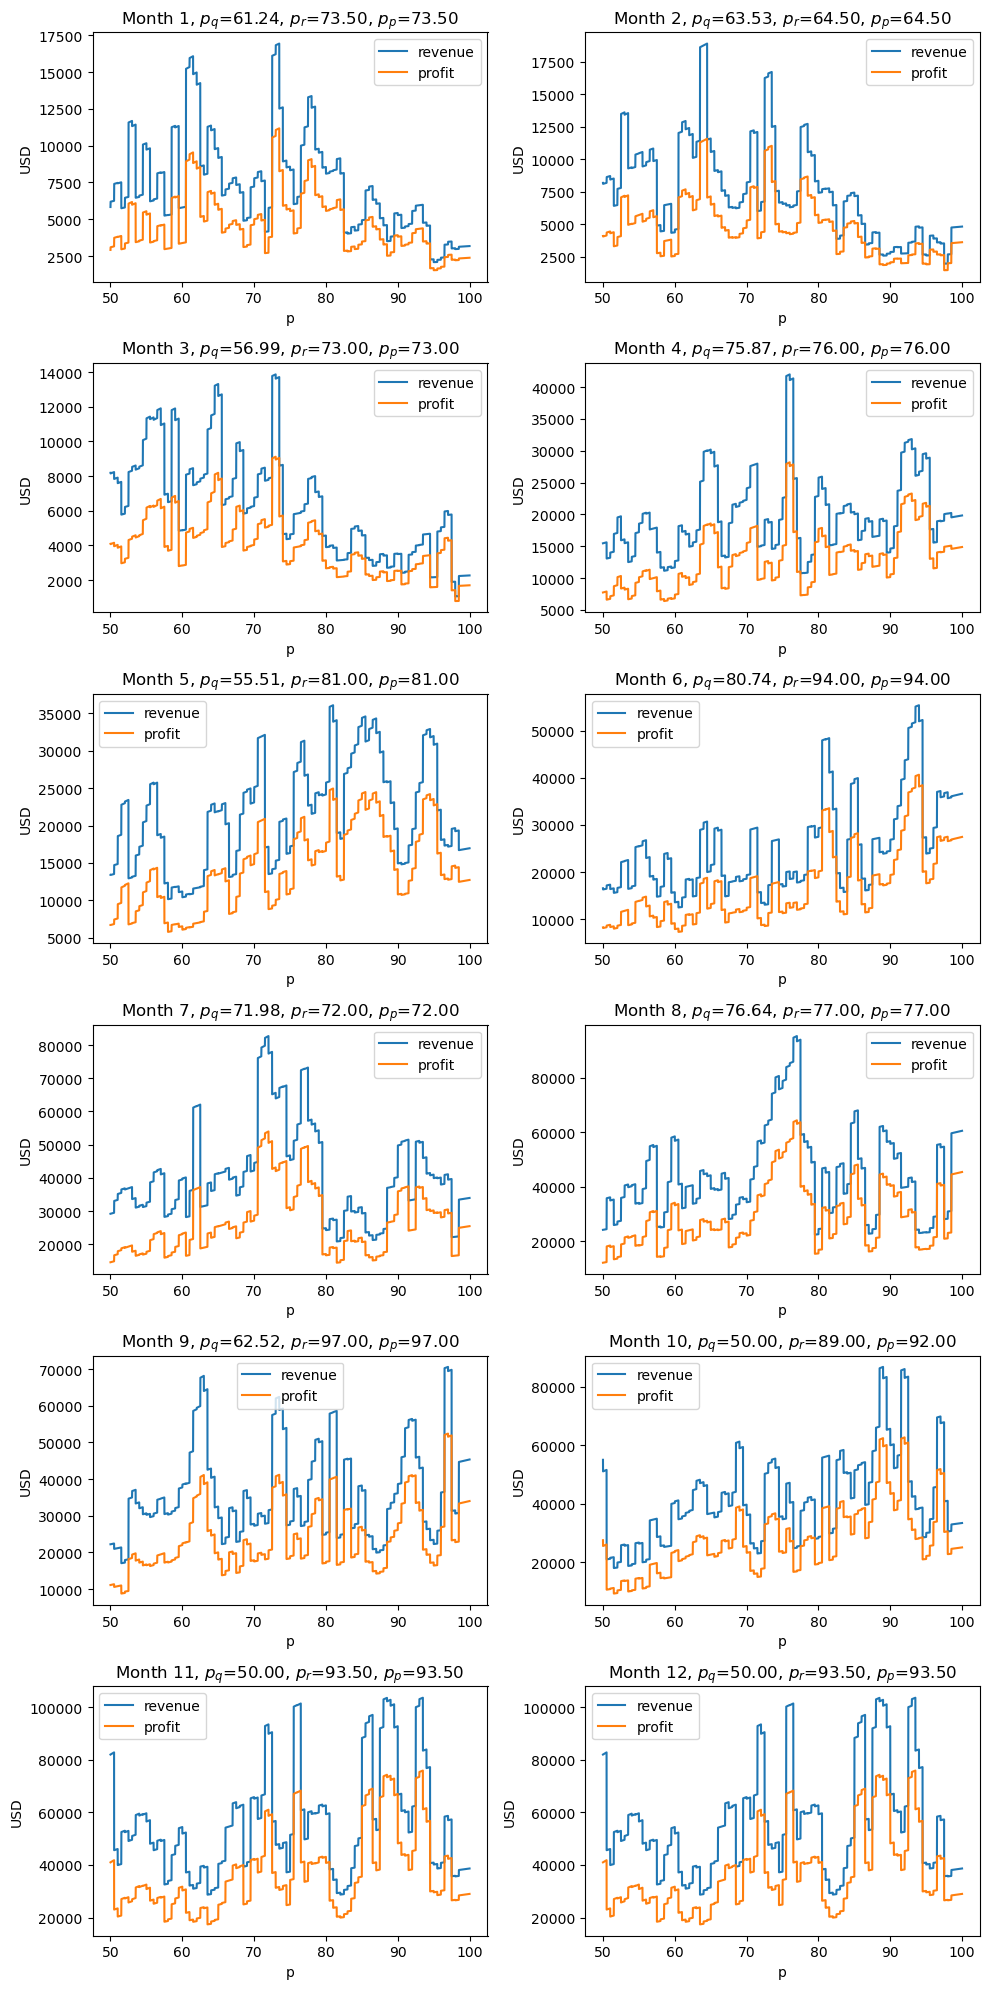

In [68]:
def get_estimate(month):
    return pd.DataFrame({'p': np.arange(50, 100.01, 0.01), 'month': month}) \
        .assign(
            q=lambda d: m.predict(d),
            revenue=lambda d: d['p'] * d['q'],
            profit=lambda d: (d['p'] - 25) * d['q']
        ) \
        .set_index(['p']) \
        [['q', 'revenue', 'profit']]

fig, axes = plt.subplots(6, 2, figsize=(10, 20))

for month, ax in zip(np.arange(1, 13, 1), np.ravel(axes)):
    _df = get_estimate(month)
    _df[['revenue', 'profit']].plot(kind='line', ax=ax)
    
    _p_qty = _df.sort_values(['q'], ascending=False).index[0]
    _p_rev = _df.sort_values(['revenue'], ascending=False).index[0]
    _p_pft = _df.sort_values(['profit'], ascending=False).index[0]
    
    ax.set_title(rf'Month {month}, $p_q$={_p_qty:.2f}, $p_r$={_p_rev:.2f}, $p_p$={_p_pft:.2f}')
    ax.set_ylabel('USD')

fig.tight_layout()

## Visualizing revenue

Because we love interactive surface plots, let's plot expected total revenue (z-axis) against price (x-axis) and month (y-axis).

In [50]:
x, y = np.meshgrid(np.arange(50, 100.1, 0.1), np.arange(1, 13, 1))
z = m.predict(pd.DataFrame([(_x, _y) for _x, _y in zip(np.ravel(x), np.ravel(y))], columns=['p', 'month'])).reshape(x.shape)
r = x * z
t = (x - 25) * z

((12, 501), (12, 501), (12, 501), (12, 501), (12, 501))

In [51]:
fig = go.Figure(data=[go.Surface(
    x=x,
    y=y,
    z=r,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$r = qp = f(p, m_q) p$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='p')
fig.update_yaxes(title=r'$m_q$')

fig.show()

## Visualizing profit

This next surface plot is of expected total profit (z-axis) against price (x-axis) and month (y-axis).

In [52]:
fig = go.Figure(data=[go.Surface(
    x=x,
    y=y,
    z=t,
    colorscale='Viridis',
    opacity=0.5,
)])

fig.update_layout(
    title=r'$t = q(p - c) = f(p, m_q) (p - c)$',
    autosize=False,
    width=600,
    height=600,
    margin={'l': 65, 'r': 50, 'b': 65, 't': 90}
)
fig.update_xaxes(title='p')
fig.update_yaxes(title=r'$m_q$')

fig.show()